In [271]:
import query_helper
import pandas as pd 
import charlie_functions
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [119]:
query_helper.set_database_name('MLB_Stats')

In [120]:
games_teams = query_helper.query_to_df("""select G.gameid, G.home_team, t.team_name as away_team, G.game_date, G.status from 
(select g.gameid, g.game_date, g.status, t.team_name as home_team, g.away_id
from MLB_Stats.games g 
inner join MLB_Stats.teams t on t.team_id=g.home_id) G
inner join MLB_Stats.teams t on t.team_id=G.away_id;""")

In [121]:
#data.groupby(data.date.dt.year)
games_per_year = games_teams.groupby(games_teams.game_date.dt.year).count()['gameid']

In [122]:
games_per_year

game_date
2009    2394
2010    2408
2011    2380
2012    2409
2013    2392
2014    2390
2015    2389
2016    2404
2017    2392
2018    2379
2019    2388
Name: gameid, dtype: int64

In [123]:
runs_games = query_helper.query_to_df("""SELECT A.gameid, A.total_runs, t.league FROM 
(SELECT g.gameid, i.home_team_runs + i.away_team_runs as total_runs, g.home_id
from games g
inner join game_info i on i.gameid=g.gameid) A
inner join teams t on t.team_id=A.home_id;""")

In [124]:
NL = runs_games[runs_games['league']=='NL']
AL = runs_games[runs_games['league']=='AL']

In [125]:
contigency = pd.crosstab(runs_games['total_runs'],runs_games['league'])
contigency

league,AL,NL
total_runs,,
1,215,298
2,242,280
3,767,916
4,643,707
5,1225,1380
6,966,954
7,1459,1454
8,1016,1034
9,1367,1386


In [126]:
NL_runs = NL['total_runs']
AL_runs = AL['total_runs']

In [127]:
NL_runs.describe(), AL_runs.describe()

(count    13174.000000
 mean         8.612722
 std          4.413306
 min          1.000000
 25%          5.000000
 50%          8.000000
 75%         11.000000
 max         30.000000
 Name: total_runs, dtype: float64, count    13147.000000
 mean         9.012779
 std          4.467761
 min          1.000000
 25%          6.000000
 50%          9.000000
 75%         12.000000
 max         32.000000
 Name: total_runs, dtype: float64)

In [128]:
#two-sided, two-sample T-Test
#Null Hyp: means are equal
#Alt Hyp: means are not equal
stats.ttest_ind(AL_runs,NL_runs)

Ttest_indResult(statistic=7.3080541043893446, pvalue=2.78752559887634e-13)

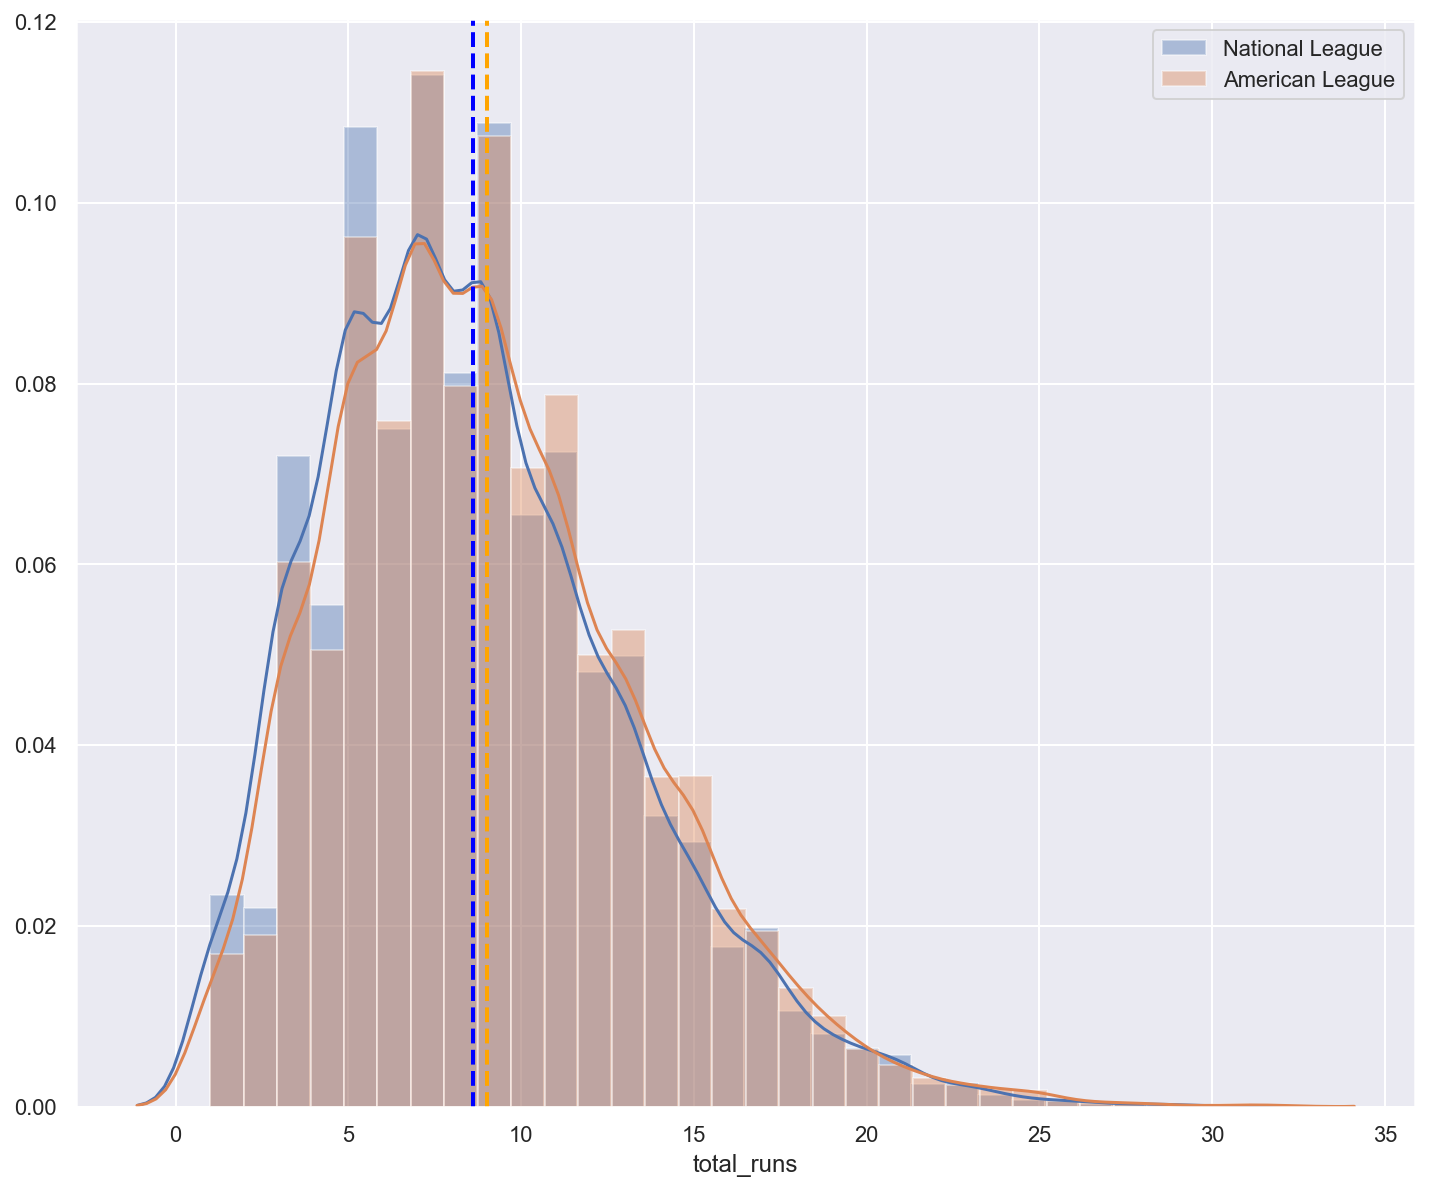

In [129]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(NL_runs,bins=NL_runs.max(),label='National League') # Blue distribution
sns.distplot(AL_runs,bins=AL_runs.max(),label='American League') # Green distribution
#plt.xticks(ticks=range(32))
plt.legend()
plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=2)
plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=2)

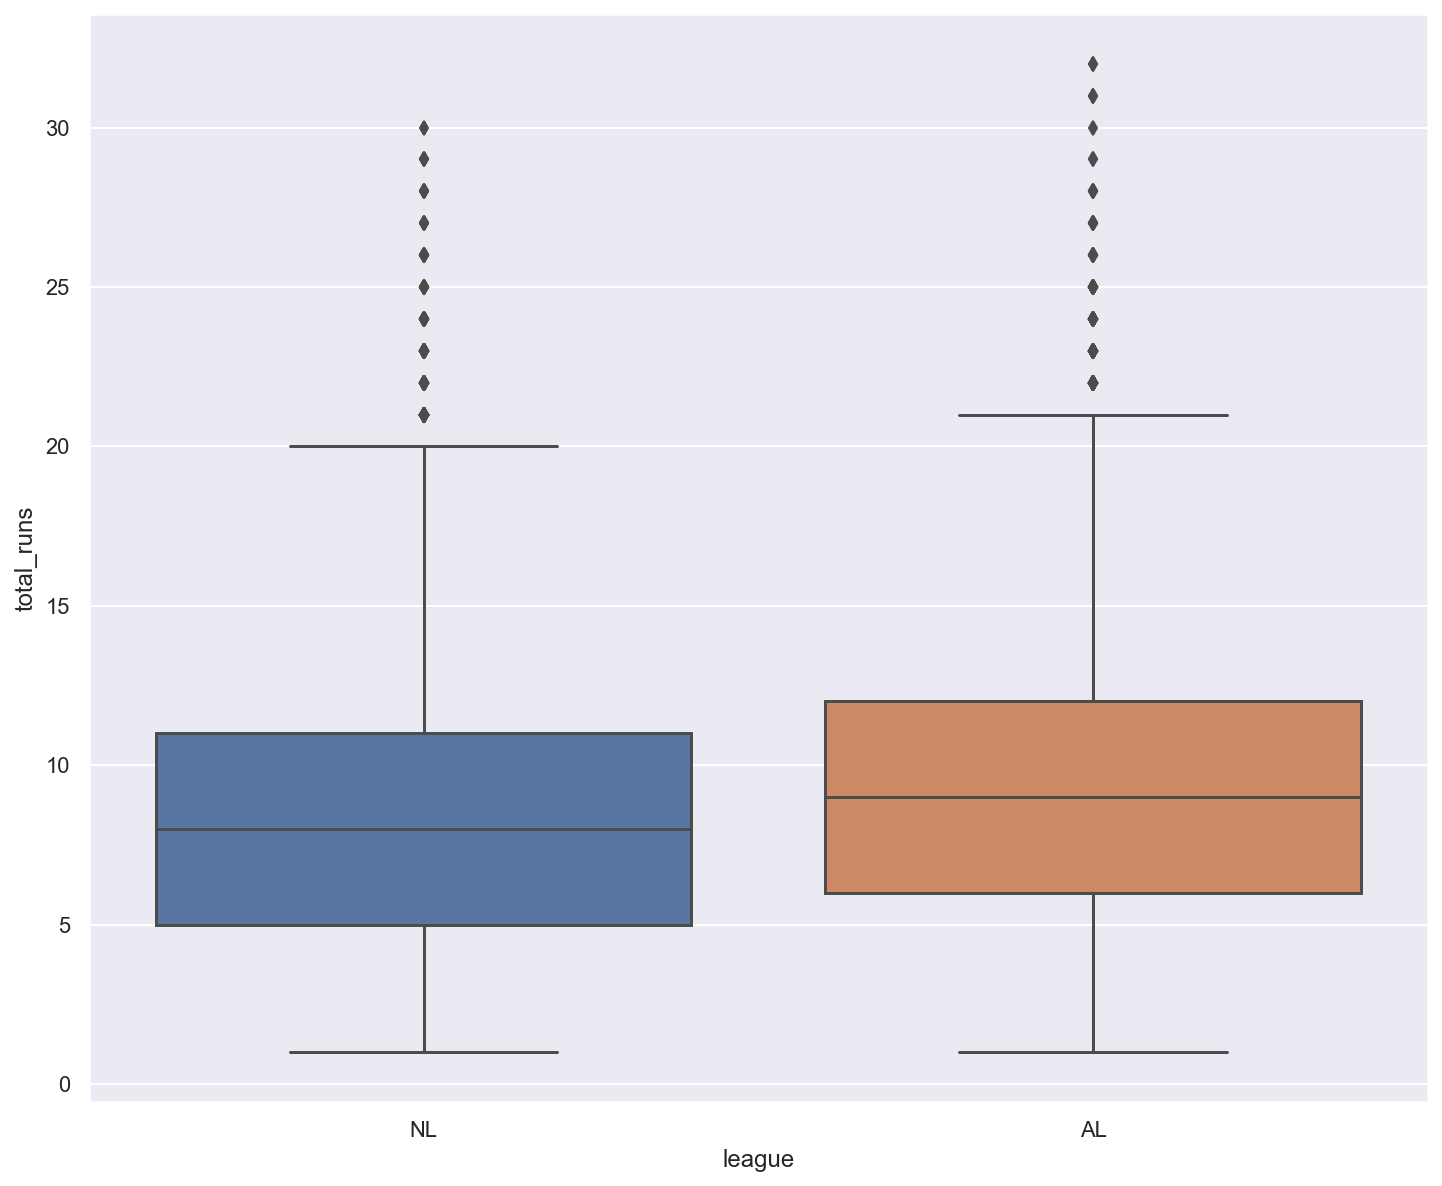

In [130]:
sns.boxplot(x=runs_games['league'],y=runs_games['total_runs'],orient='v')
#sns.boxplot(AL_runs,orient='v')

In [131]:
NL_samples = [np.random.choice(NL_runs, replace=False, size=30) for i in range(len(NL_runs/30))]
AL_samples = [np.random.choice(AL_runs, replace=False, size=30) for i in range(len(AL_runs/30))]

In [132]:
NL_sampleMeans = [np.mean(i) for i in NL_samples]
AL_sampleMeans = [np.mean(i) for i in AL_samples]

Text(0.5, 0, 'Mean Runs Scored per Game')

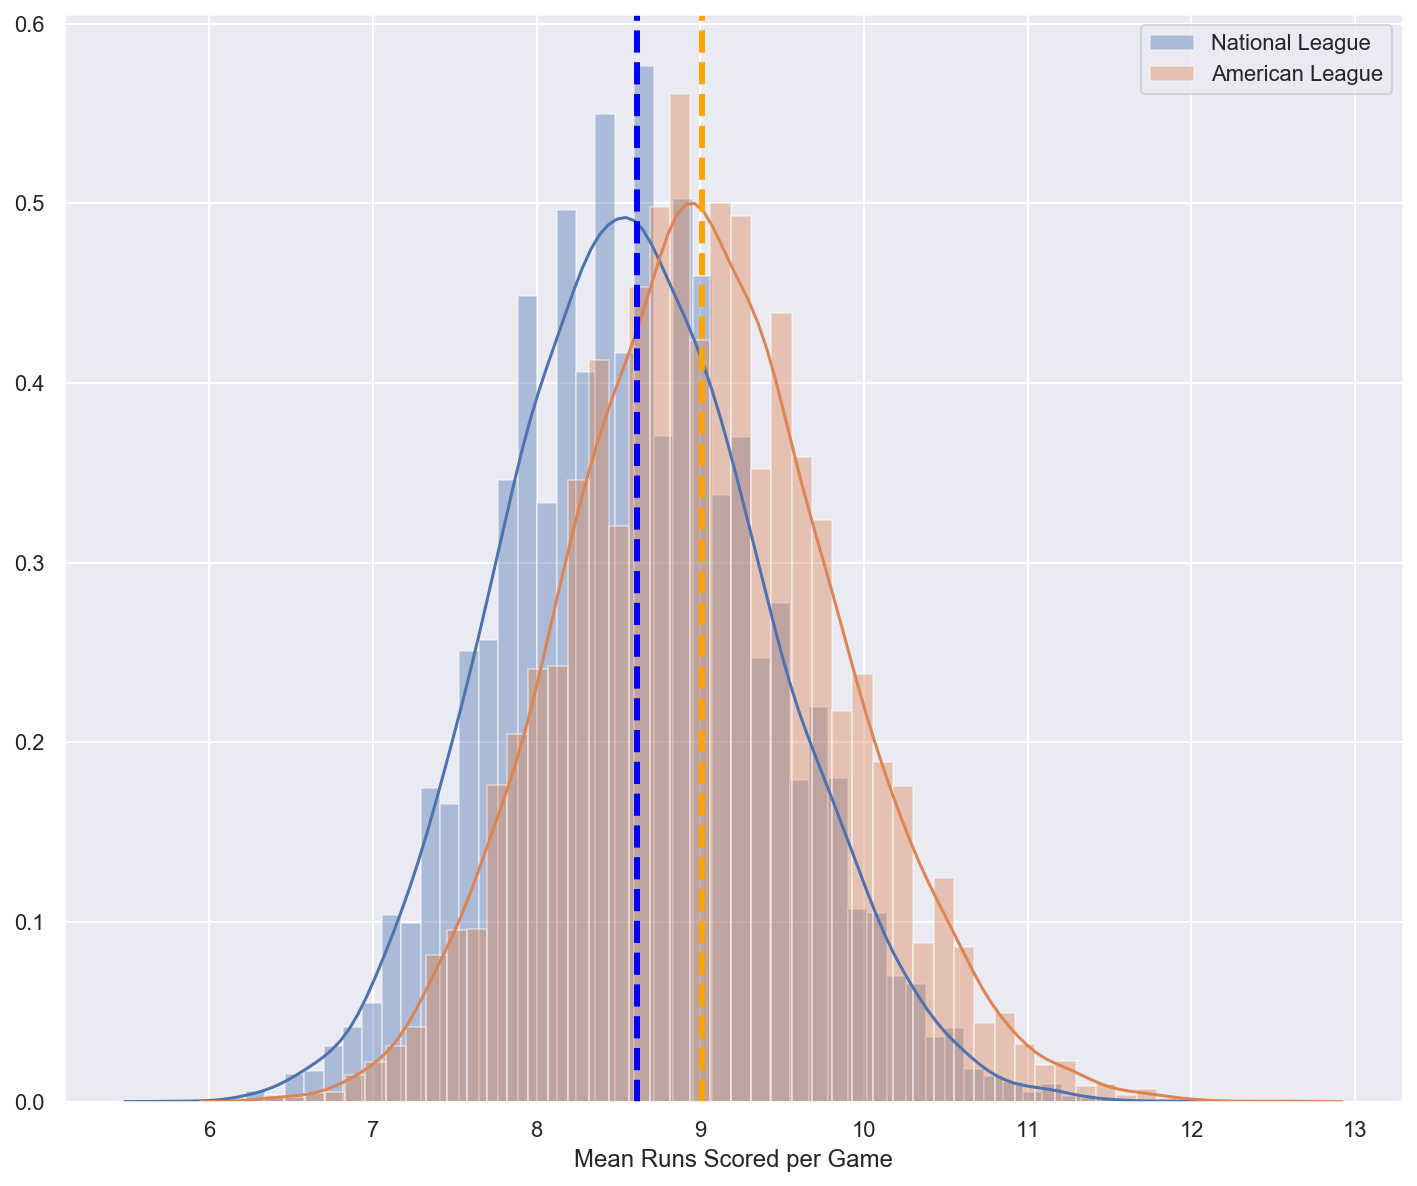

In [133]:
sns.distplot(NL_sampleMeans,label='National League')
sns.distplot(AL_sampleMeans,label='American League')
plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=3)
plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=3)
plt.legend()
plt.xlabel('Mean Runs Scored per Game')

In [134]:
AL_mean = np.mean(AL_runs)
NL_mean = np.mean(NL_runs)

NL_std = np.std(NL_runs)
AL_std = np.std(AL_runs)

NL_n = len(NL_runs)
AL_n = len(AL_runs)

numer = (AL_mean-NL_mean)
denom = np.sqrt((NL_std**2/NL_n)+(AL_std**2/AL_n))

print(numer,denom)

0.40005655242735294 0.05474047939554291


In [135]:
Z = numer/denom

In [136]:
Z

7.308239840879552

In [137]:
P_value = 1-stats.norm.cdf(Z)
alpha = .001
P_value < alpha

True

In [138]:
pooled_SD = np.sqrt((NL_std**2 + AL_std**2)/2)
cohens_d = (AL_mean - NL_mean)/pooled_SD
cohens_d

0.09009372728428088

- attempt to visualize our two-sample z test 

In [139]:
NL_Zscores = stats.zscore(NL_runs)
AL_Zscores = stats.zscore(AL_runs)

In [140]:
NL_Zscores

array([-0.81862869,  1.90052441, -0.81862869, ..., -0.36543651,
       -1.04522479, -0.36543651])

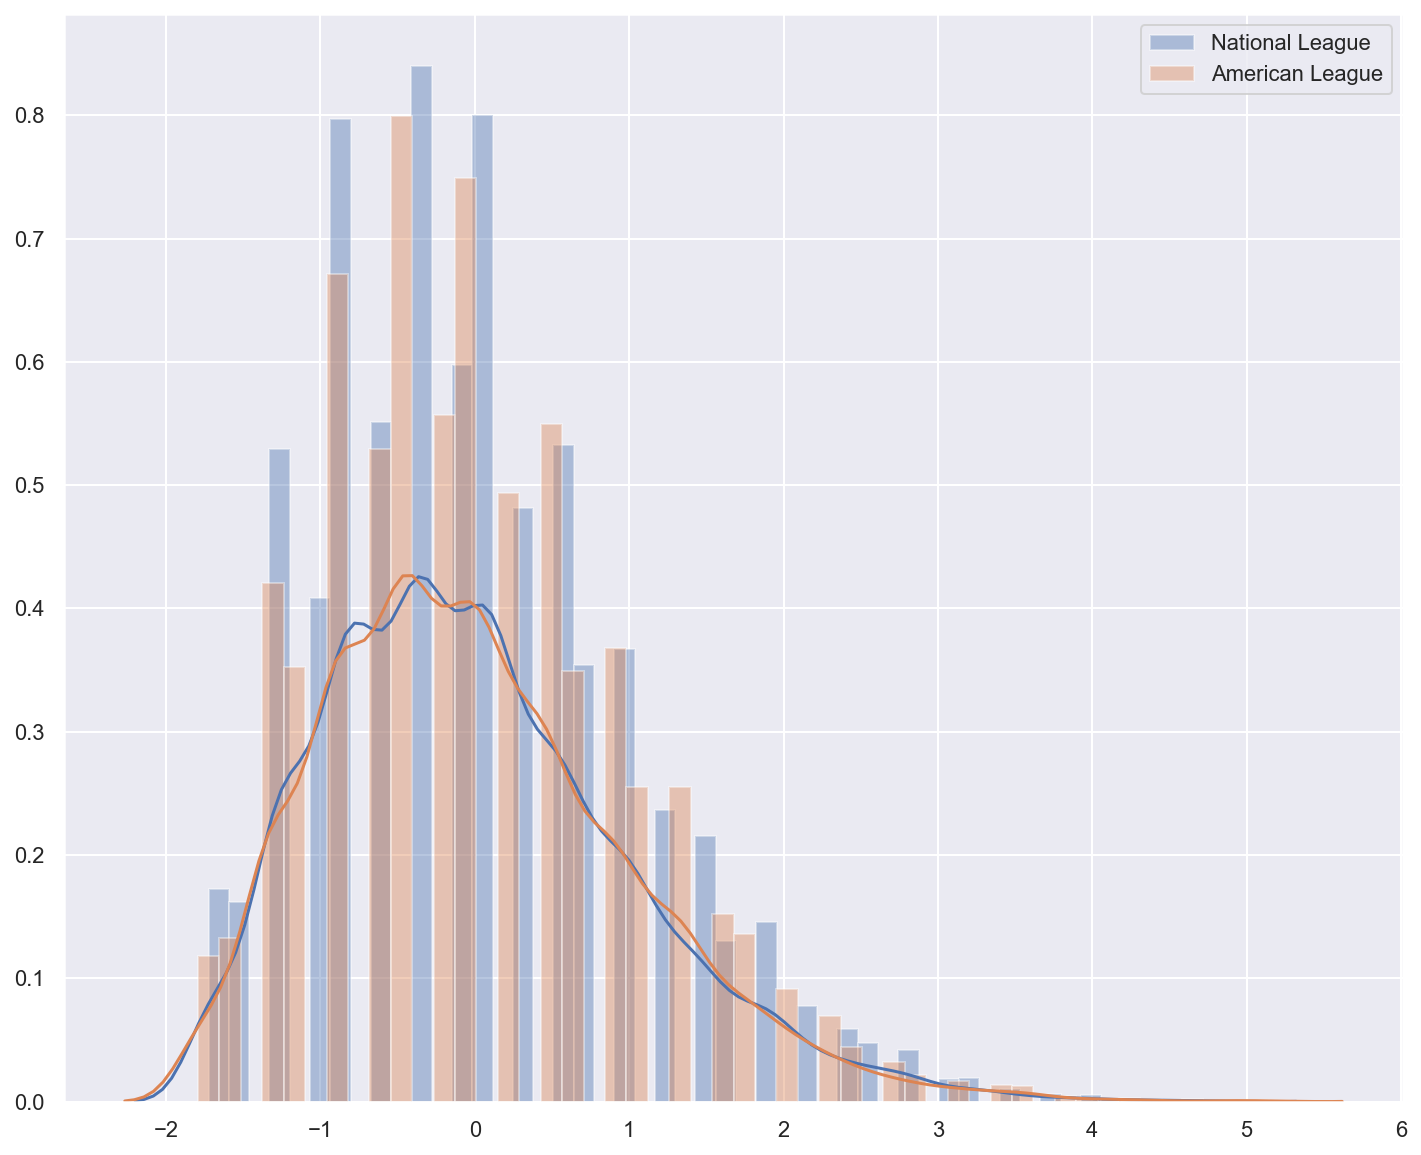

In [141]:
sns.distplot(NL_Zscores,label='National League')
sns.distplot(AL_Zscores,label='American League')
#plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=3)
#plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=3)
plt.legend()

In [142]:
NL_skew = stats.skew(NL_runs)
AL_skew = stats.skew(AL_runs)
print(NL_skew,AL_skew)

0.7606128171412102 0.7540337783692563


- moving on to weather 


In [143]:
df_weather = query_helper.query_to_df("""select 
i.home_team_runs + i.away_team_runs as total_runs, i.weather_category
from 
MLB_Stats.game_info i;""")

In [144]:
snow = df_weather[df_weather['weather_category']=='snow'].index
df_weather.drop(snow,inplace=True)

In [145]:
categories = list(df_weather['weather_category'].unique())
categories

['clear',
 'roof closed',
 'sunny',
 'overcast',
 'cloudy',
 'dome',
 'partly cloudy',
 'rain',
 'drizzle']

In [146]:
weather_dfs = [df_weather[df_weather['weather_category']==i] for i in categories]

In [147]:
weather_dfs[-1].head()

,total_runs,weather_category
190,5,drizzle
279,8,drizzle
368,13,drizzle
511,9,drizzle
520,15,drizzle


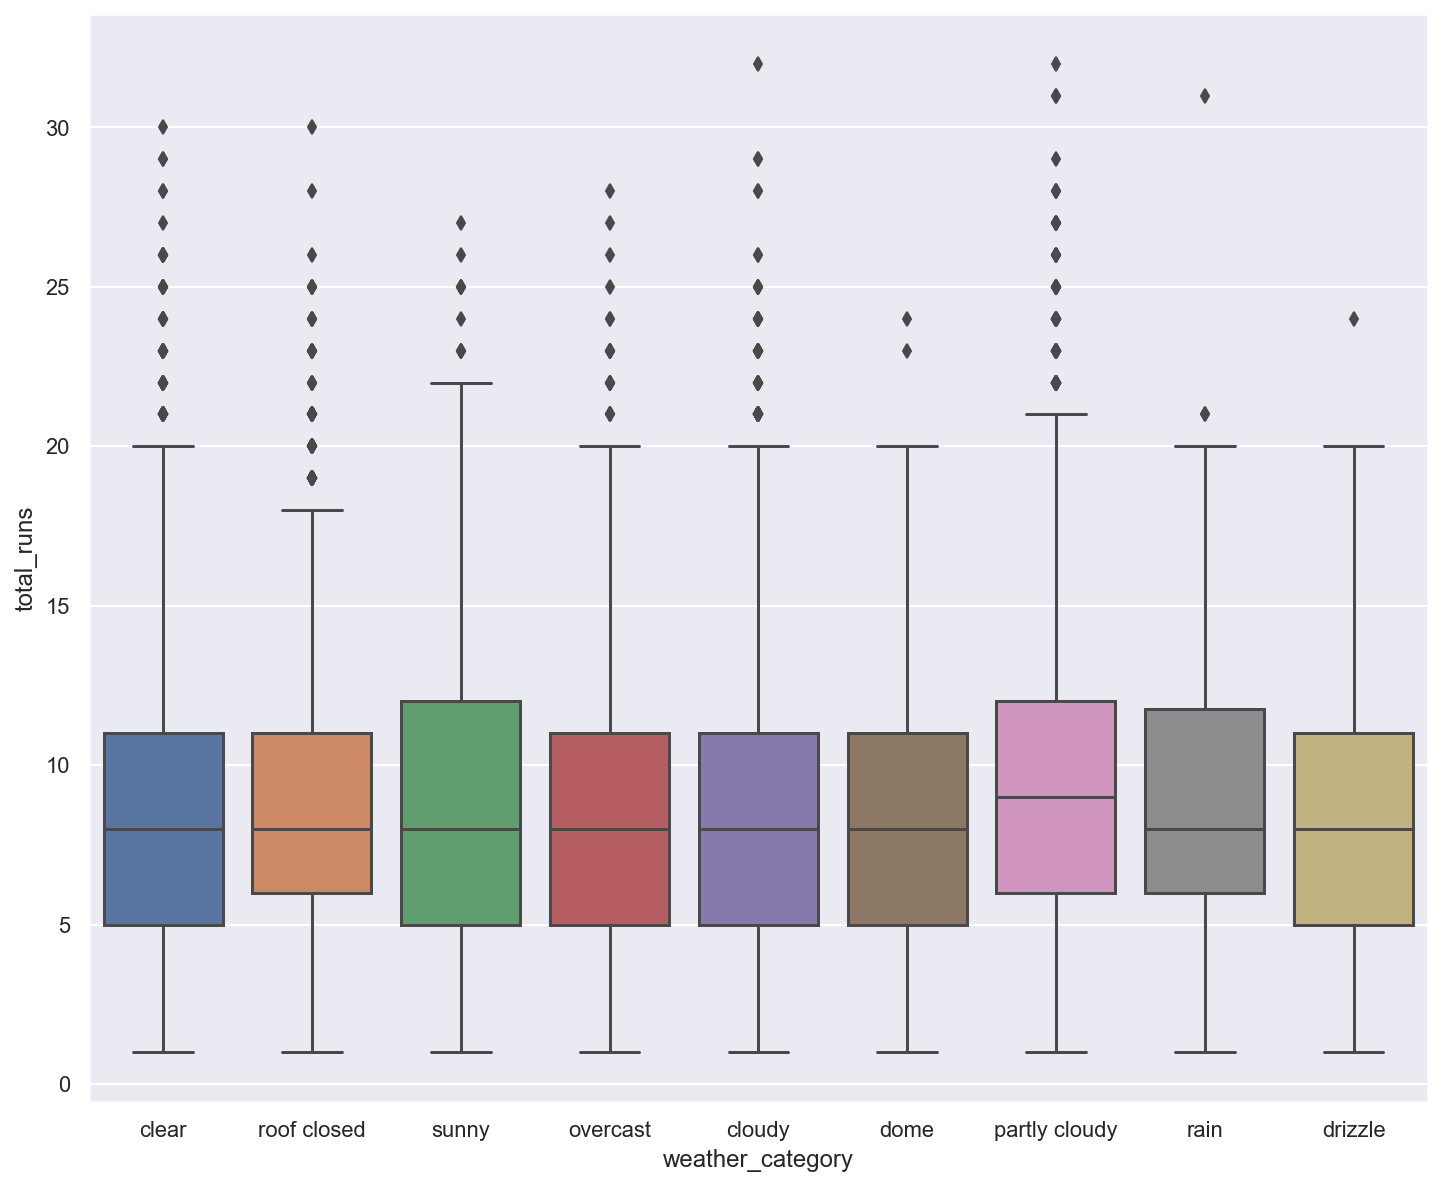

In [148]:
sns.boxplot(x=df_weather['weather_category'],y=df_weather['total_runs'],orient='v')

In [149]:
x = [(i,df_weather[df_weather['weather_category']==i].shape[0]) for i in categories]
x

[('clear', 5148),
 ('roof closed', 2711),
 ('sunny', 2580),
 ('overcast', 1573),
 ('cloudy', 4666),
 ('dome', 988),
 ('partly cloudy', 8324),
 ('rain', 142),
 ('drizzle', 187)]

In [150]:
df_weather[df_weather['weather_category']=='rain'].shape

(142, 2)

In [151]:
rainy = ['rain','drizzle']
df_rain = df_weather[df_weather.weather_category.isin(rainy)]
df_rain 

clear = ['clear','sunny']

In [153]:
df_temp = query_helper.query_to_df("""select 
i.home_team_runs + i.away_team_runs as total_runs, i.temp
from 
MLB_Stats.game_info i;""")

In [154]:
df_temp['temp_group'] = df['temp']

,total_runs,temp
0,5,60
1,6,66
2,10,49
3,17,80
4,17,68
...,...,...
26316,11,79
26317,11,78
26318,7,77
26319,4,65


In [171]:
df = query_helper.query_to_df("""select G.gameid, G.home_team, t.team_name as away_team, G.league from (select g.gameid, t.team_name as home_team, t.league, g.away_id
from MLB_Stats.games g 
inner join MLB_Stats.teams t on t.team_id=g.home_id) G
inner join MLB_Stats.teams t on t.team_id=G.away_id;""")

In [172]:
df

,gameid,home_team,away_team,league
0,244193,Philadelphia Phillies,Atlanta Braves,NL
1,244194,Houston Astros,Chicago Cubs,AL
2,244195,Texas Rangers,Cleveland Indians,AL
3,244196,Arizona Diamondbacks,Colorado Rockies,NL
4,244197,Toronto Blue Jays,Detroit Tigers,AL
...,...,...,...,...
26320,567630,Milwaukee Brewers,Pittsburgh Pirates,NL
26321,567631,Milwaukee Brewers,Pittsburgh Pirates,NL
26322,567632,Milwaukee Brewers,Pittsburgh Pirates,NL
26323,570334,Chicago Cubs,Milwaukee Brewers,NL


In [188]:
df_venue = query_helper.query_to_df("""
    select 
    i.gameid, i.away_team_runs+i.home_team_runs as run_total,
    v.`name` as venue_name
    from game_info i
    inner join venues v
    on i.venue_id=v.venue_id;""")

In [189]:
df_venue_teams = df_venue.merge(df,how='inner',on='gameid')
df_venue_teams

,gameid,run_total,venue_name,home_team,away_team,league
0,244193,5,Citizens Bank Park,Philadelphia Phillies,Atlanta Braves,NL
1,244194,6,Minute Maid Park,Houston Astros,Chicago Cubs,AL
2,244195,10,Rangers Ballpark in Arlington,Texas Rangers,Cleveland Indians,AL
3,244196,17,Chase Field,Arizona Diamondbacks,Colorado Rockies,NL
4,244197,17,Rogers Centre,Toronto Blue Jays,Detroit Tigers,AL
...,...,...,...,...,...,...
26316,567630,11,Miller Park,Milwaukee Brewers,Pittsburgh Pirates,NL
26317,567631,11,Miller Park,Milwaukee Brewers,Pittsburgh Pirates,NL
26318,567632,7,Miller Park,Milwaukee Brewers,Pittsburgh Pirates,NL
26319,570334,4,Wrigley Field,Chicago Cubs,Milwaukee Brewers,NL


In [192]:
df_venue_teams['home_team'].unique()
df_venue_teams[df_venue_teams['league']=='NL']['home_team'].unique()

array(['Philadelphia Phillies', 'Arizona Diamondbacks',
       'San Diego Padres', 'Cincinnati Reds', 'St. Louis Cardinals',
       'Miami Marlins', 'San Francisco Giants', 'Milwaukee Brewers',
       'Colorado Rockies', 'Atlanta Braves', 'Chicago Cubs',
       'Pittsburgh Pirates', 'Washington Nationals', 'New York Mets',
       'Los Angeles Dodgers'], dtype=object)

In [246]:
division_map = {'Boston Red Sox': 'AL_east',
 'New York Yankees': 'AL_east',
 'Tampa Bay Rays': 'AL_east',
 'Toronto Blue Jays': 'AL_east',
 'Baltimore Orioles': 'AL_east',
 'Minnesota Twins':'AL_central', 
 'Kansas City Royals':'AL_central', 
 'Detroit Tigers':'AL_central', 
 'Chicago White Sox':'AL_central', 
 'Cleveland Indians':'AL_central',
 'Los Angeles Angels':'AL_west', 
 'Oakland Athletics':'AL_west', 
 'Seattle Mariners':'AL_west',
 'Texas Rangers':'AL_west',
 'Houston Astros':'AL_west',
 'Philadelphia Phillies':'NL_east', 
 'Miami Marlins':'NL_east', 
 'New York Mets':'NL_east', 
 'Atlanta Braves':'NL_east', 
 'Washington Nationals':'NL_east',
 'St. Louis Cardinals':'NL_central', 
 'Milwaukee Brewers':'NL_central', 
 'Chicago Cubs':'NL_central',
 'Cincinnati Reds':'NL_central',
 'Pittsburgh Pirates':'NL_central',
 'Los Angeles Dodgers':'NL_west', 
 'Arizona Diamondbacks':'NL_west',
 'San Francisco Giants':'NL_west',
 'Colorado Rockies':'NL_west',
 'San Diego Padres':'NL_west'}

In [247]:
df_venue_teams.head()

,gameid,run_total,venue_name,home_team,away_team,league,division
0,244193,5,Citizens Bank Park,Philadelphia Phillies,Atlanta Braves,NL,0
1,244194,6,Minute Maid Park,Houston Astros,Chicago Cubs,AL,0
2,244195,10,Rangers Ballpark in Arlington,Texas Rangers,Cleveland Indians,AL,0
3,244196,17,Chase Field,Arizona Diamondbacks,Colorado Rockies,NL,0
4,244197,17,Rogers Centre,Toronto Blue Jays,Detroit Tigers,AL,0


In [248]:
df_venue_teams['division'] = df['home_team'].map(lambda x : division_map[x])

In [249]:
df_venue_teams.head()

,gameid,run_total,venue_name,home_team,away_team,league,division
0,244193,5,Citizens Bank Park,Philadelphia Phillies,Atlanta Braves,NL,NL_east
1,244194,6,Minute Maid Park,Houston Astros,Chicago Cubs,AL,AL_west
2,244195,10,Rangers Ballpark in Arlington,Texas Rangers,Cleveland Indians,AL,AL_west
3,244196,17,Chase Field,Arizona Diamondbacks,Colorado Rockies,NL,NL_west
4,244197,17,Rogers Centre,Toronto Blue Jays,Detroit Tigers,AL,AL_east


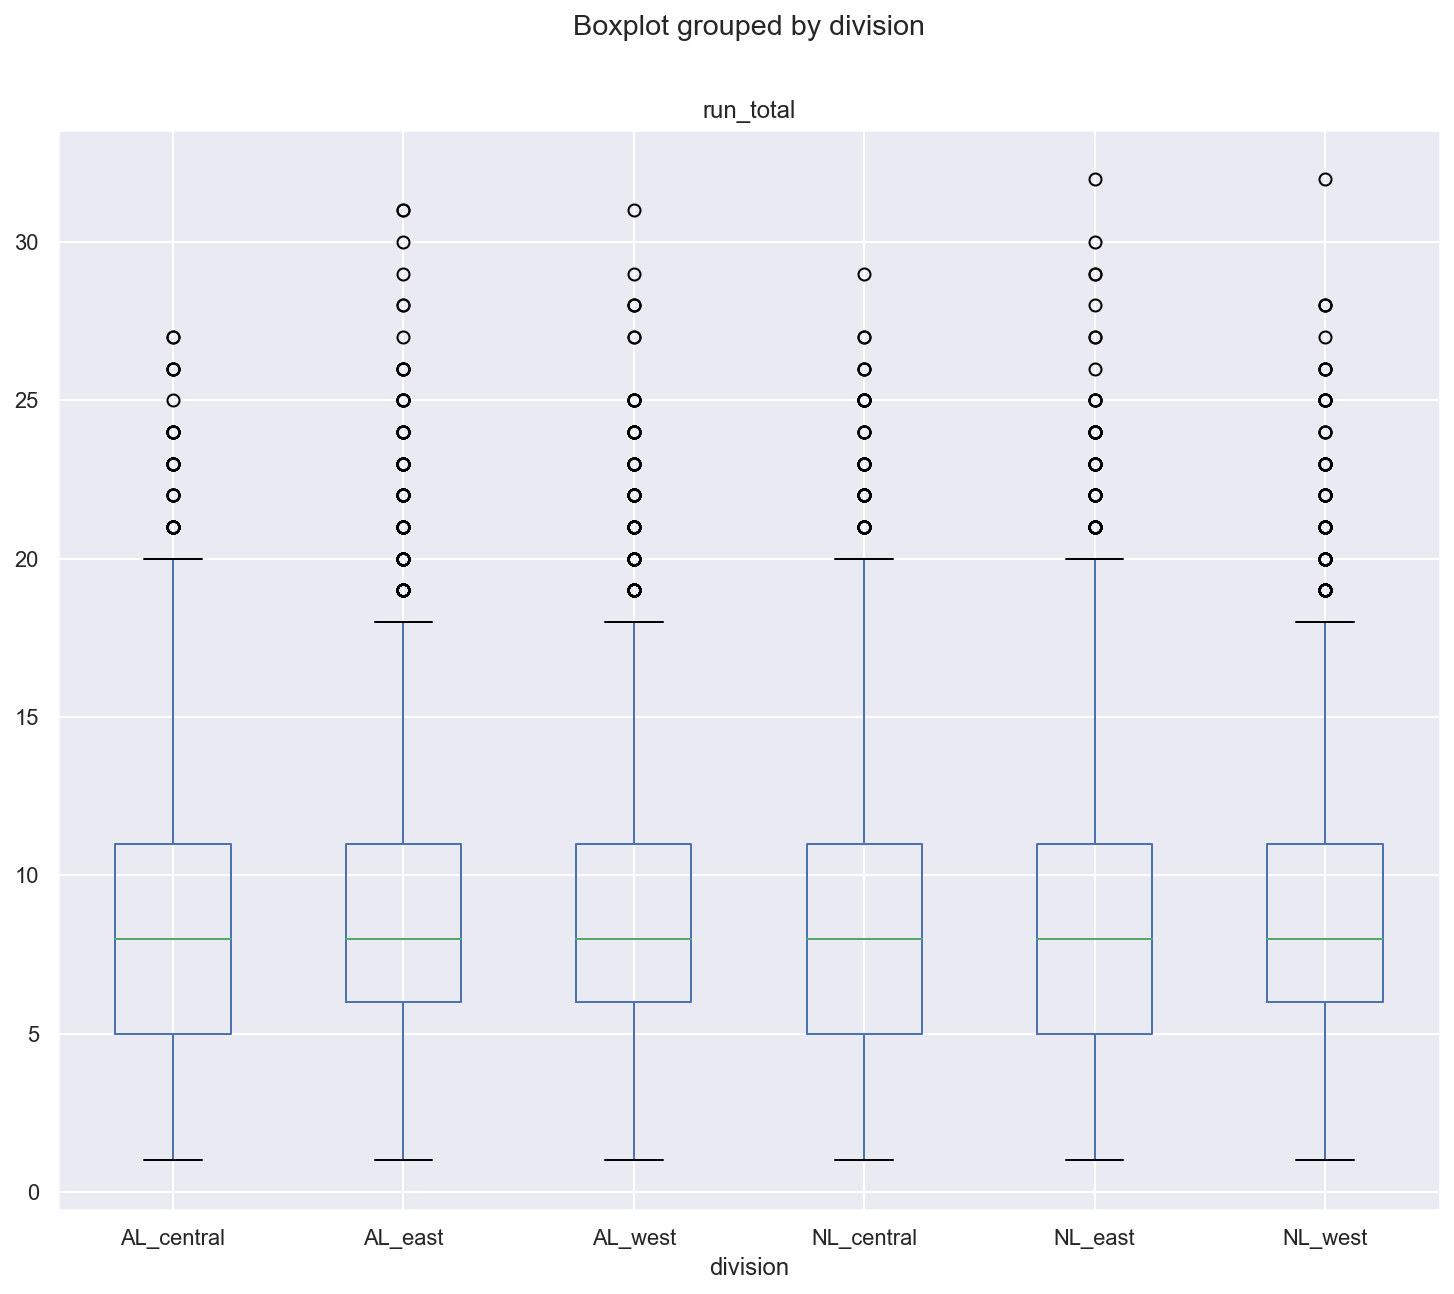

In [251]:
df_venue_teams.boxplot('run_total', by='division')

In [267]:
# df_rain = df_weather[df_weather.weather_category.isin(rainy)]

df_ALeast = df_venue_teams[df_venue_teams['division']=='AL_east']

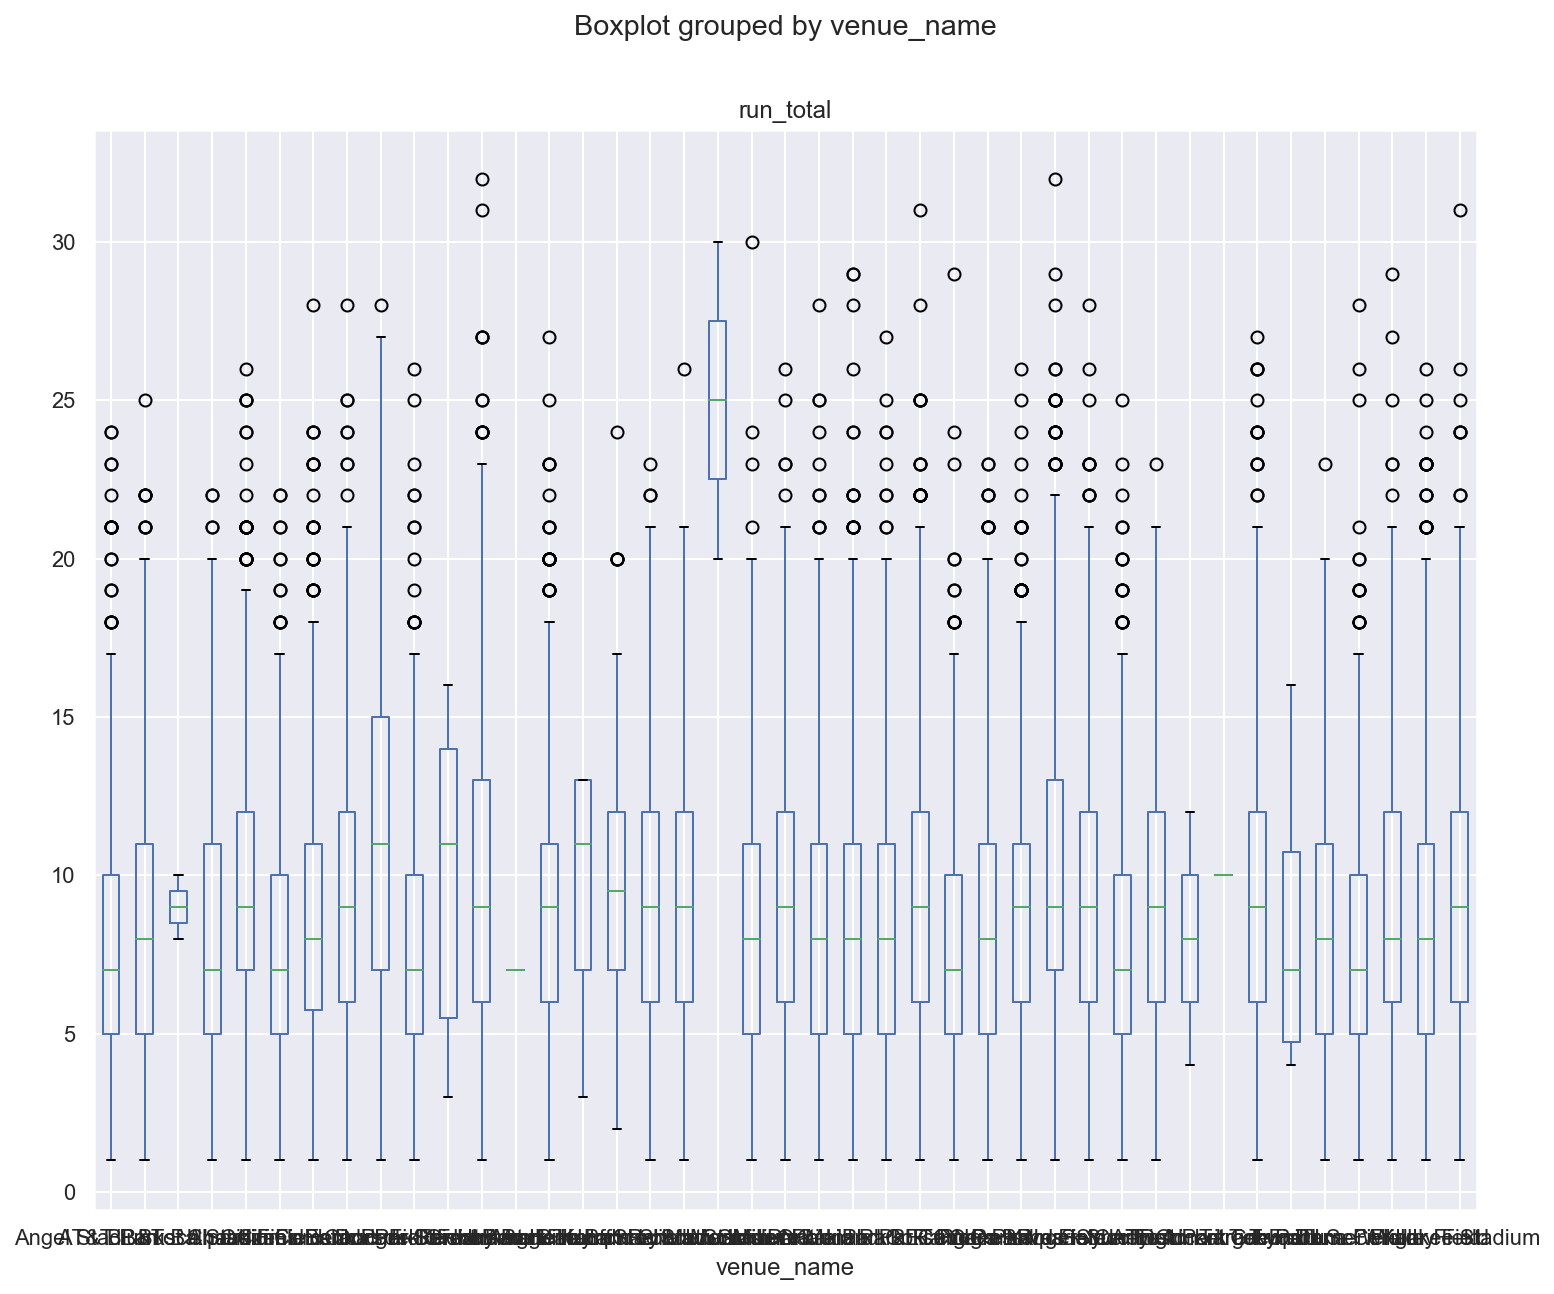

In [270]:
df_venue_teams.boxplot('run_total', by='venue_name')

In [277]:
pivot = df_venue_teams[['run_total','venue_name']]

In [279]:
formula = 'run_total ~ C(venue_name)'
lm = ols(formula, df_venue_teams).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq       df          F         PR(>F)
C(venue_name)   17413.376862     40.0  22.761917  6.387905e-162
Residual       502619.720740  26280.0        NaN            NaN
